In [23]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline
# !pip install pennylane custatevec-cu11 pennylane-lightning-gpu
import time
seconds = time.time()
print("Time in seconds since beginning of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since beginning of run: 1700379676.1201804
Sun Nov 19 07:41:16 2023


An equivariant graph embedding
==============================

::: {.meta}
:property=\"og:description\": Find out more about how to embedd graphs
into quantum states. :property=\"og:image\":
<https://pennylane.ai/qml/_images/thumbnail_tutorial_equivariant_graph_embedding.png>
:::

::: {.related}
tutorial\_geometric\_qml Geometric quantum machine learning
:::


A notorious problem when data comes in the form of graphs \-- think of
molecules or social media networks \-- is that the numerical
representation of a graph in a computer is not unique. For example, if
we describe a graph via an [adjacency
matrix](https://en.wikipedia.org/wiki/Adjacency_matrix) whose entries
contain the edge weights as off-diagonals and node weights on the
diagonal, any simultaneous permutation of rows and columns of this
matrix refer to the same graph.

![](../demonstrations/equivariant_graph_embedding/adjacency-matrices.png){.align-center
width="60.0%"}

For example, the graph in the image above is represented by each of the
two equivalent adjacency matrices. The top matrix can be transformed
into the bottom matrix by swapping the first row with the third row,
then swapping the third column with the third column, then the new first
row with the second, and finally the first colum with the second.

But the number of such permutations grows factorially with the number of
nodes in the graph, which is even worse than an exponential growth!

If we want computers to learn from graph data, we usually want our
models to \"know\" that all these permuted adjacency matrices refer to
the same object, so we do not waste resources on learning this property.
In mathematical terms, this means that the model should be in- or
equivariant (more about this distinction below) with respect to
permutations. This is the basic motivation of [Geometric Deep
Learning](https://geometricdeeplearning.com/), ideas of which have found
their way into quantum machine learning.

This tutorial shows how to implement an example of a trainable
permutation equivariant graph embedding as proposed in [Skolik et al.
(2022)](https://arxiv.org/pdf/2205.06109.pdf). The embedding maps the
adjacency matrix of an undirected graph with edge and node weights to a
quantum state, such that permutations of an adjacency matrix get mapped
to the same states *if only we also permute the qubit registers in the
same fashion*.

::: {.note}
::: {.title}
Note
:::

The tutorial is meant for beginners and does not contain the
mathematical details of the rich theory of equivariance. Have a look [at
this demo](https://pennylane.ai/qml/demos/tutorial_geometric_qml.html)
if you want to know more.
:::

Permuted adjacency matrices describe the same graph
===================================================

Let us first verify that permuted adjacency matrices really describe one
and the same graph. We also gain some useful data generation functions
for later.

First we create random adjacency matrices. The entry $a_{ij}$ of this
matrix corresponds to the weight of the edge between nodes $i$ and $j$
in the graph. We assume that graphs have no self-loops; instead, the
diagonal elements of the adjacency matrix are interpreted as node
weights (or \"node attributes\").

Taking the example of a Twitter user retweet network, the nodes would be
users, edge weights indicate how often two users retweet each other and
node attributes could indicate the follower count of a user.


In [24]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


def create_data_point(n):
    """
    Returns a random undirected adjacency matrix of dimension (n,n).
    The diagonal elements are interpreted as node attributes.
    """
    mat = np.random.rand(n, n)
    A = (mat + np.transpose(mat))/2
    return np.round(A, decimals=2)

A = create_data_point(3)
print(A)

[[0.62 0.51 0.49]
 [0.51 0.46 0.2 ]
 [0.49 0.2  0.35]]


Let\'s also write a function to generate permuted versions of this
adjacency matrix.


In [25]:
def permute(A, permutation):
    """
    Returns a copy of A with rows and columns swapped according to permutation.
    For example, the permutation [1, 2, 0] swaps 0->1, 1->2, 2->0.
    """

    P = np.zeros((len(A), len(A)))
    for i,j in enumerate(permutation):
        P[i,j] = 1

    return P @ A @ np.transpose(P)

A_perm = permute(A, [1, 2, 0])
print(A_perm)

[[0.46 0.2  0.51]
 [0.2  0.35 0.49]
 [0.51 0.49 0.62]]


If we create [networkx]{.title-ref} graphs from both adjacency matrices
and plot them, we see that they are identical as claimed.


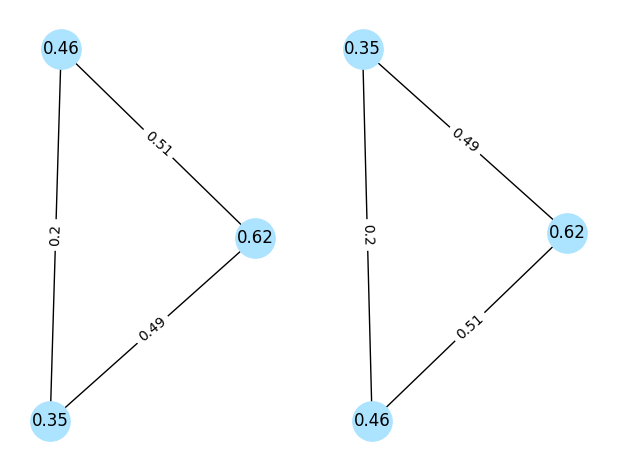

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2)

# interpret diagonal of matrix as node attributes
node_labels = {n: A[n,n] for n in range(len(A))}
np.fill_diagonal(A, np.zeros(len(A)))

G1 = nx.Graph(A)
pos1=nx.spring_layout(G1)
nx.draw(G1, pos1, labels=node_labels, ax=ax1, node_size = 800, node_color = "#ACE3FF")
edge_labels = nx.get_edge_attributes(G1,'weight')
nx.draw_networkx_edge_labels(G1,pos1,edge_labels=edge_labels, ax=ax1)

# interpret diagonal of permuted matrix as node attributes
node_labels = {n: A_perm[n,n] for n in range(len(A_perm))}
np.fill_diagonal(A_perm, np.zeros(len(A)))

G2 = nx.Graph(A_perm)
pos2=nx.spring_layout(G2)
nx.draw(G2, pos2, labels=node_labels, ax=ax2, node_size = 800, node_color = "#ACE3FF")
edge_labels = nx.get_edge_attributes(G2,'weight')
nx.draw_networkx_edge_labels(G2,pos2,edge_labels=edge_labels, ax=ax2)

ax1.set_xlim([1.2*x for x in ax1.get_xlim()])
ax2.set_xlim([1.2*x for x in ax2.get_xlim()])
plt.tight_layout()
plt.show()

::: {.note}
::: {.title}
Note
:::

The issue of non-unique numerical representations of graphs ultimately
stems from the fact that the nodes in a graph do not have an intrinsic
order, and by labelling them in a numerical data structure like a matrix
we therefore impose an arbitrary order.
:::

Permutation equivariant embeddings
==================================

When we design a machine learning model that takes graph data, the first
step is to encode the adjacency matrix into a quantum state using an
embedding or [quantum feature
map](https://pennylane.ai/qml/glossary/quantum_feature_map.html) $\phi$:

$$A \rightarrow |\phi(A)\rangle .$$

We may want the resulting quantum state to be the same for all adjacency
matrices describing the same graph. In mathematical terms, this means
that $\phi$ is an *invariant* embedding with respect to simultaneous row
and column permutations $\pi(A)$ of the adjacency matrix:

$$|\phi(A) \rangle = |\phi(\pi(A))\rangle \;\; \text{ for all } \pi .$$

However, invariance is often too strong a constraint. Think for example
of an encoding that associates each node in the graph with a qubit. We
might want permutations of the adjacency matrix to lead to the same
state *up to an equivalent permutation of the qubits* $P_{\pi}$, where

$$P_{\pi} |q_1,...,q_n \rangle = |q_{\textit{perm}_{\pi}(1)}, ... q_{\textit{perm}_{\pi}(n)} \rangle .$$

The function $\text{perm}_{\pi}$ maps each index to the permuted index
according to $\pi$.

::: {.note}
::: {.title}
Note
:::

The operator $P_{\pi}$ is implemented by PennyLane\'s
`~pennylane.Permute`{.interpreted-text role="class"}.
:::

This results in an *equivariant* embedding with respect to permutations
of the adjacency matrix:

$$|\phi(A) \rangle = P_{\pi}|\phi(\pi(A))\rangle \;\; \text{ for all } \pi .$$

This is exactly what the following quantum embedding is aiming to do!
The mathematical details behind these concepts use group theory and are
beautiful, but can be a bit daunting. Have a look at [this
paper](https://arxiv.org/abs/2210.08566) if you want to learn more.

Implementation in PennyLane
===========================

Let\'s get our hands dirty with an example. As mentioned, we will
implement the permutation-equivariant embedding suggested in [Skolik et
al. (2022)](https://arxiv.org/pdf/2205.06109.pdf) which has this
structure:

![](../demonstrations/equivariant_graph_embedding/circuit.png){.align-center
width="70.0%"}

The image can be found in [Skolik et al.
(2022)](https://arxiv.org/pdf/2205.06109.pdf) and shows one layer of the
circuit. The $\epsilon$ are our edge weights while $\alpha$ describe the
node weights, and the $\beta$, $\gamma$ are variational parameters.

In PennyLane this looks as follows:


In [27]:
import pennylane as qml

def perm_equivariant_embedding(A, betas, gammas):
    """
    Ansatz to embedd a graph with node and edge weights into a quantum state.

    The adjacency matrix A contains the edge weights on the off-diagonal,
    as well as the node attributes on the diagonal.

    The embedding contains trainable weights 'betas' and 'gammas'.
    """
    n_nodes = len(A)
    n_layers = len(betas) # infer the number of layers from the parameters

    # initialise in the plus state
    for i in range(n_nodes):
        qml.Hadamard(i)

    for l in range(n_layers):

        for i in range(n_nodes):
            for j in range(i):
            	# factor of 2 due to definition of gate
                qml.IsingZZ(2*gammas[l]*A[i,j], wires=[i,j])

        for i in range(n_nodes):
            qml.RX(A[i,i]*betas[l], wires=i)

We can use this ansatz in a circuit.


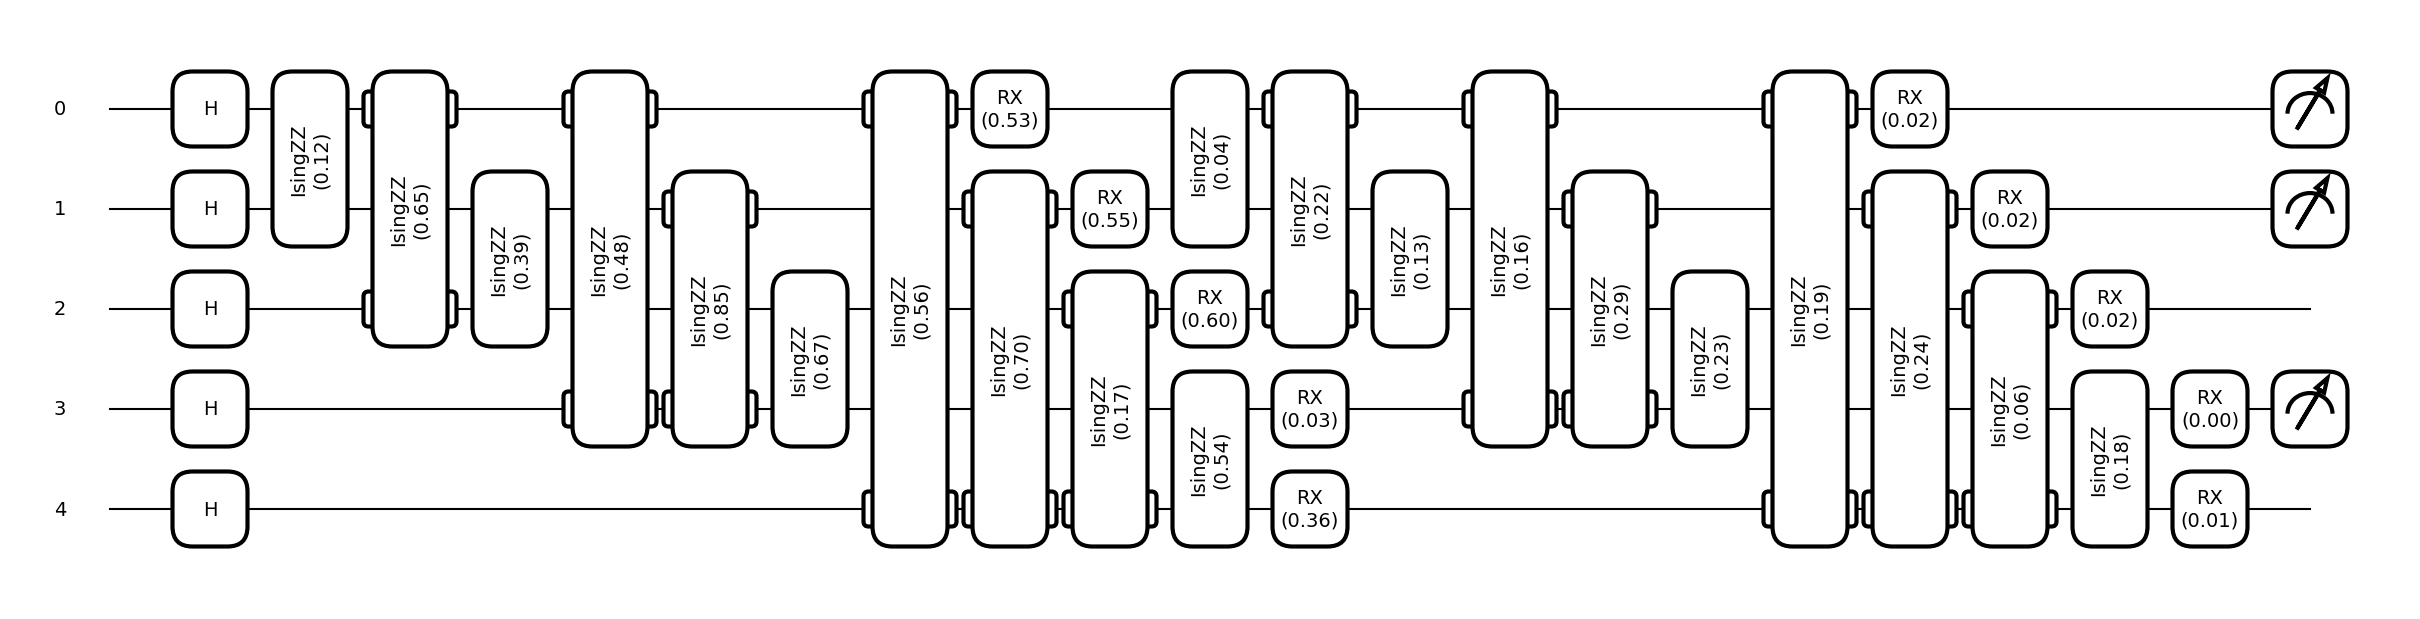

In [28]:
n_qubits = 5
n_layers = 2

dev = qml.device("lightning.gpu", wires=n_qubits)

@qml.qnode(dev, diff_method="adjoint")
def eqc(adjacency_matrix, observable, trainable_betas, trainable_gammas):
    """Circuit that uses the permutation equivariant embedding"""

    perm_equivariant_embedding(adjacency_matrix, trainable_betas, trainable_gammas)
    return qml.expval(observable)


A = create_data_point(n_qubits)
betas = np.random.rand(n_layers)
gammas = np.random.rand(n_layers)
observable = qml.PauliX(0) @ qml.PauliX(1) @ qml.PauliX(3)

qml.draw_mpl(eqc, decimals=2)(A, observable, betas, gammas)
plt.show()

Validating the equivariance
===========================

Let\'s now check if the circuit is really equivariant!

This is the expectation value we get using the original adjacency matrix
as an input:


In [29]:
result_A = eqc(A, observable, betas, gammas)
print("Model output for A:", result_A)

Model output for A: 0.4200109706653141


If we permute the adjacency matrix, this is what we get:


In [30]:
perm = [2, 3, 0, 1, 4]
A_perm = permute(A, perm)
result_Aperm = eqc(A_perm, observable, betas, gammas)
print("Model output for permutation of A: ", result_Aperm)

Model output for permutation of A:  0.236328502946865


Why are the two values different? Well, we constructed an *equivariant*
ansatz, not an *invariant* one! Remember, an *invariant* ansatz means
that embedding a permutation of the adjacency matrix leads to the same
state as an embedding of the original matrix. An *equivariant* ansatz
embeds the permuted adjacency matrix into a state where the qubits are
permuted as well.

As a result, the final state before measurement is only the same if we
permute the qubits in the same manner that we permute the input
adjacency matrix. We could insert a permutation operator
`qml.Permute(perm)` to achieve this, or we simply permute the wires of
the observables!


In [31]:
observable_perm = qml.PauliX(perm[0]) @ qml.PauliX(perm[1]) @ qml.PauliX(perm[3])

Now everything should work out!


In [32]:
result_Aperm = eqc(A_perm, observable_perm, betas, gammas)
print("Model output for permutation of A, and with permuted observable: ", result_Aperm)

Model output for permutation of A, and with permuted observable:  0.4200109706653141


Et voilà!

Conclusion
==========

Equivariant graph embeddings can be combined with other equivariant
parts of a quantum machine learning pipeline (like measurements and the
cost function). [Skolik et al.
(2022)](https://arxiv.org/pdf/2205.06109.pdf), for example, use such a
pipeline as part of a reinforcement learning scheme that finds heuristic
solutions for the traveling salesman problem. Their simulations compare
a fully equivariant model to circuits that break permutation
equivariance and show that it performs better, confirming that if we
know about structure in our data, we should try to use this knowledge in
machine learning.

References
==========

1.  Andrea Skolik, Michele Cattelan, Sheir Yarkoni,Thomas Baeck and
    Vedran Dunjko (2022). Equivariant quantum circuits for learning on
    weighted graphs.
    [arXiv:2205.06109](https://arxiv.org/abs/2205.06109)
2.  Quynh T. Nguyen, Louis Schatzki, Paolo Braccia, Michael Ragone,
    Patrick J. Coles, Frédéric Sauvage, Martín Larocca and Marco Cerezo
    (2022). Theory for Equivariant Quantum Neural Networks.
    [arXiv:2210.08566](https://arxiv.org/abs/2210.08566)

About the author
================


In [33]:
seconds = time.time()
print("Time in seconds since end of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since end of run: 1700379677.3346224
Sun Nov 19 07:41:17 2023
